In [89]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import cm
from matplotlib.pyplot import figure
from xml.etree import ElementTree as et
from xml.dom import minidom
from scipy.spatial.transform import Rotation as R
%matplotlib inline

# Карты

## Карта 1

In [79]:

map_size_1 = (200, 200) # pixels
map_1 = np.zeros(map_size_1)
resolution = 0.05 # meters

center = (100, 100) # pixels
r_big = 70 # pixels
r_small = 30 # pixels
top_height = 2.5 # meters

full_height = r_big/(r_big - r_small) * top_height

for i in range(map_size_1[0]):
    for j in range(map_size_1[1]):
        if ((i - center[0]) ** 2 + (j - center[1]) ** 2 <= r_big ** 2 ):
            if ((i - center[0]) ** 2 + (j - center[1]) ** 2 <= r_small ** 2 ):
                map_1[i, j] = top_height
            else:
                v = np.array([(i - center[0]), (j - center[1])])
                dist = r_big - np.linalg.norm(v)
                map_1[i, j] = dist/r_big * full_height
            
            
min_x_1 = -map_size_1[0]/2 * resolution
max_x_1 = map_size_1[0]/2  * resolution
min_y_1 = -map_size_1[0]/2  * resolution
max_y_1 = map_size_1[0]/2  * resolution

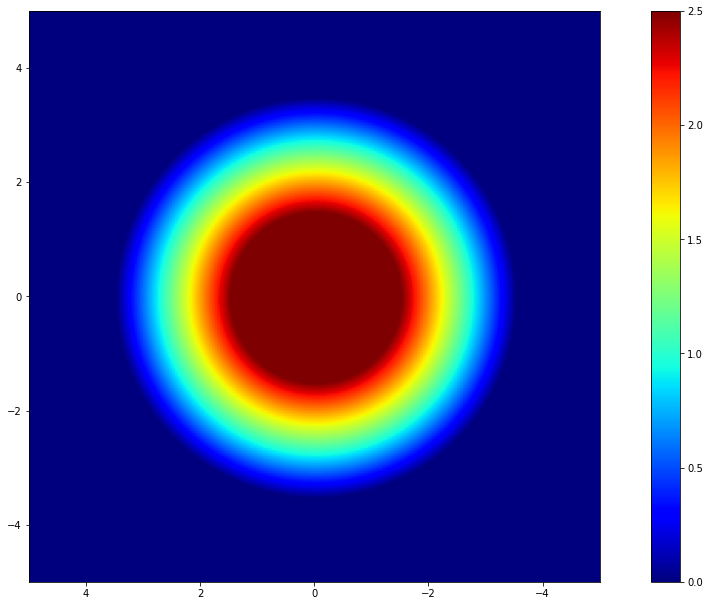

In [80]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
p = plt.imshow(map_1, cmap='jet', extent=[max_y_1, min_y_1, min_x_1, max_x_1])
plt.colorbar(p)
plt.show()

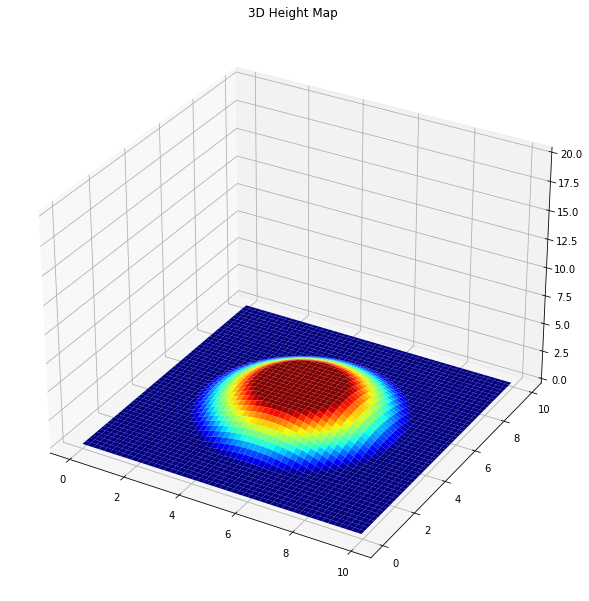

In [70]:
z = map_1
x_real = resolution * np.array(range(z.shape[0]))
y_real = resolution * np.array(range(z.shape[1]))
x, y = np.meshgrid(x_real, y_real)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='jet')
ax.set_zlim(0,20)

plt.title('3D Height Map')
plt.show()


## Карта 2

In [71]:
map_size_2 = (250, 150) # pixels
map_2 = np.zeros(map_size_2) 
resolution = 0.05 # meters

box_height = 0.5 # meters
box_len = 100 # pixels

center_j = map_size_2[1] // 2 

ramp_len = 100 # pixels
box_width = 80 # pixels

map_2[:box_len, :] = box_height

for i in range(box_len, box_len + ramp_len):
    for j in range(center_j - box_width // 2,  center_j + box_width // 2):
        map_2[i, j] = -(i - box_len - ramp_len) / ramp_len * box_height


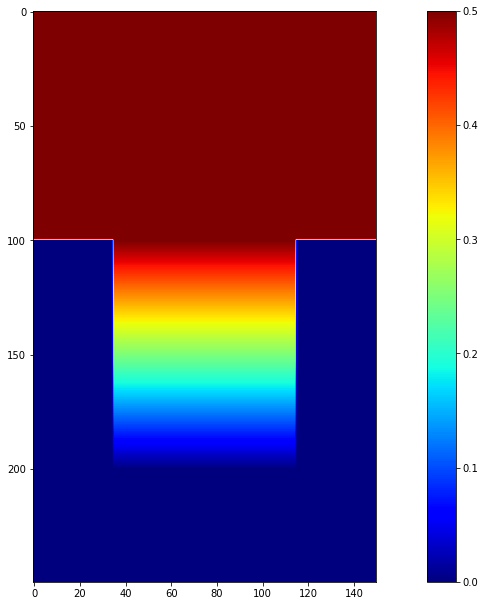

In [72]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
p = plt.imshow(map_2, cmap='jet')
plt.colorbar(p)
plt.show()

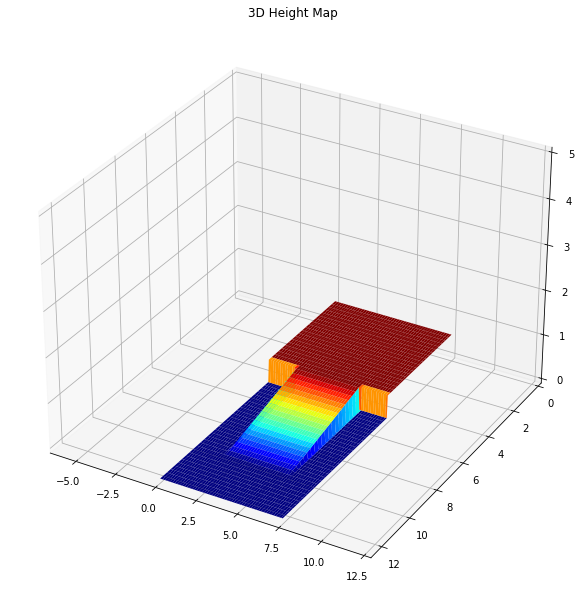

In [73]:
z = map_2
x_real = resolution * np.array(range(z.shape[1]))
y_real = resolution * np.array(range(z.shape[0]))
x, y = np.meshgrid(x_real, y_real)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='jet')
ax.set_zlim(0,5)
ax.set_ylim(z.shape[0] * resolution ,0)
ax.set_xlim(-z.shape[0] * resolution/2, z.shape[0] * resolution)

plt.title('3D Height Map')
plt.show()

## Карта 3

In [74]:
map_size_3 = (250, 150) # pixels
map_3 = np.zeros(map_size_2)
resolution = 0.05 # meters

hole_center = (125, 35) # pixels
hole_half_size = (5, 35) # pixels
hole_depth = 0.1 # meters

map_3[hole_center[0] - hole_half_size[0]:hole_center[0] + hole_half_size[0], 
      hole_center[1] - hole_half_size[1]:hole_center[1] + hole_half_size[1]] = -hole_depth


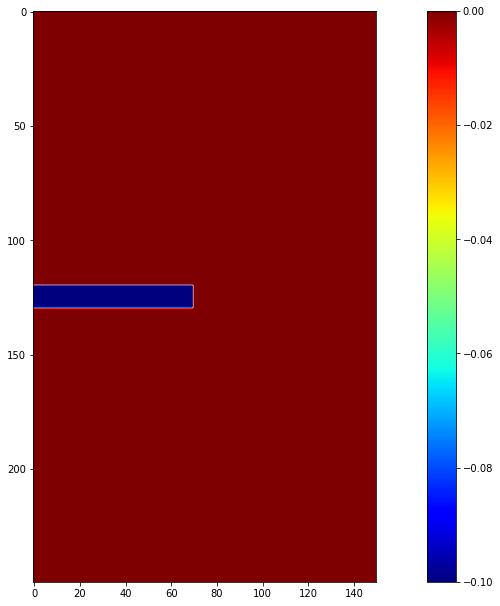

In [75]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
p = plt.imshow(map_3, cmap='jet')
plt.colorbar(p)
plt.show()

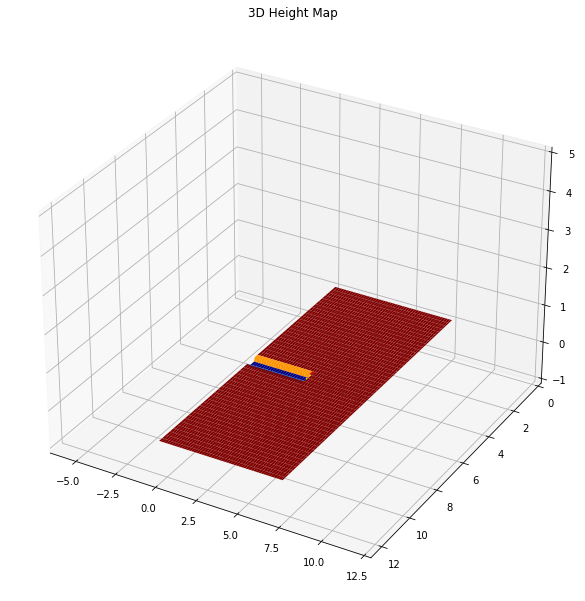

In [76]:
z = map_3
x_real = resolution * np.array(range(z.shape[1]))
y_real = resolution * np.array(range(z.shape[0]))
x, y = np.meshgrid(x_real, y_real)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='jet')
ax.set_zlim(-1,5)
ax.set_ylim(z.shape[0] * resolution ,0)
ax.set_xlim(-z.shape[0] * resolution/2, z.shape[0] * resolution)

plt.title('3D Height Map')
plt.show()

# Оценки путей

- Средний перепад высот $H$
- Длина пути $L$
- Средний наклон $S$ и отклониение футпринта $R$ (?)

## Средний перепад высот

$$
H(\pi) = \frac{1}{n} \sum_{i = 0}^{n-1}{\Delta z(\pi_i, \pi_{i+1})}
$$


 - $\pi$ - полученный путь
 - $n$ - число шагов в пути

In [13]:
def mean_height_diff(height_map, path, size):
    # TODO
    pass

## Длина пути

- Расчитывается только для путей, где не содержится слишком больших перепадов высот между шагами
- Учет перепада высоты в длине пути

$$
L(\pi) = \sum_{i = 0}^{n-1}{dist(\pi_i, \pi_{i+1})}
$$

$$
dist(a, b) = \sqrt{(a_x - b_x)^2 + (a_y - b_y)^2 + (a_z - b_z)^2}
$$

 - $\pi$ - полученный путь
 - $n$ - число шагов в пути

In [14]:
def path_len(height_map, path, size):
    # TODO
    pass

## Средний наклон и отклониение футпринта

Функции из одного из предложанных методов оценки пути внутри MPPI

![method](img/method.png)

In [15]:
def slope(height_map, path, size):
    # TODO
    pass


def roughness(height_map, path, size):
    # TODO
    pass


# Генерация XML

In [23]:
def prettify(elem):
    rough_string = et.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

In [55]:
def map_xml_generator(height_map, resolution, file_path):

    root = et.Element('map')
    
    width = height_map.shape[1]
    height = height_map.shape[0]
    
    res = et.SubElement(root, 'resolution')
    res.text = str(resolution)
    
    w = et.SubElement(root, 'width')
    w.text = str(width)
    
    h = et.SubElement(root, 'height')
    h.text = str(height)
    
    grid = et.SubElement(root, 'grid')
    
    for row in height_map:
        row_tag = et.SubElement(grid, 'row')
        row_tag.text = ' '.join(map(str, row))
        
    map_file = open(file_path, "w")

    print(prettify(root), file=map_file)
    map_file.close()


In [60]:
def task_xml_generator(starts, goals, file_path):
    
    root = et.Element('tasks')
    for i in range(len(starts)):
        task =  et.SubElement(root, 'task', {"id" : str(i)})
        
        start = et.SubElement(task, 'start', {"pos_x" : str(starts[i][0]), 
                                             "pos_y" : str(starts[i][1]), 
                                             "q_x" : str(starts[i][2]), 
                                             "q_y" : str(starts[i][3]), 
                                             "q_z" : str(starts[i][4]), 
                                             "q_w" : str(starts[i][5])})
        
        goal = et.SubElement(task, 'goal', {"pos_x" : str(goals[i][0]), 
                                     "pos_y" : str(goals[i][1]), 
                                     "q_x" : str(goals[i][2]), 
                                     "q_y" : str(goals[i][3]), 
                                     "q_z" : str(goals[i][4]), 
                                     "q_w" : str(goals[i][5])})

        
    tasks_file = open(file_path, "w")
    print(prettify(root), file=tasks_file)
    tasks_file.close()

In [61]:
pos_x, pos_y, q_x, q_y, q_z, q_w = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
starts = [(pos_x, pos_y, q_x, q_y, q_z, q_w)] * 11
goals = [(pos_x, pos_y, q_x, q_y, q_z, q_w)] * 11

task_xml_generator(starts, goals, "tasks.xml")

# Генерация заданий

In [123]:
def quaternion_from_vector(vector_2d):
    vec1=np.array([1, 0, 0])
    vec2=np.array([vector_2d[0], vector_2d[1], 0])
    
    vec1 = np.reshape(vec1, (1, -1))
    vec2 = np.reshape(vec2, (1, -1))
    
    r = R.align_vectors(vec2, vec1)
#     print(r[0].as_euler('zyx', degrees=True))
    return r[0].as_quat()
    

## Карта 1

In [132]:
number_of_tasks = 100


starts = []
goals = []


size = 0.2
start_pos = (4.5 ,0)

goals_y = np.random.uniform(-4.5, 4.5, number_of_tasks)

for i in range(number_of_tasks):
    goal_pos = (-4.5, goals_y[i])
    q = quaternion_from_vector(np.array(goal_pos) - np.array(start_pos))
    starts.append((start_pos[0], start_pos[1], q[0], q[1], q[2], q[3]))
    goals.append((goal_pos[0], goal_pos[1], q[0], q[1], q[2], q[3]))

task_xml_generator(starts, goals, "tasks_map_1.xml")
map_xml_generator(map_1, resolution, "map_1.xml")

/tmp/ipykernel_13349/4143714207.py:8: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r = R.align_vectors(vec2, vec1)


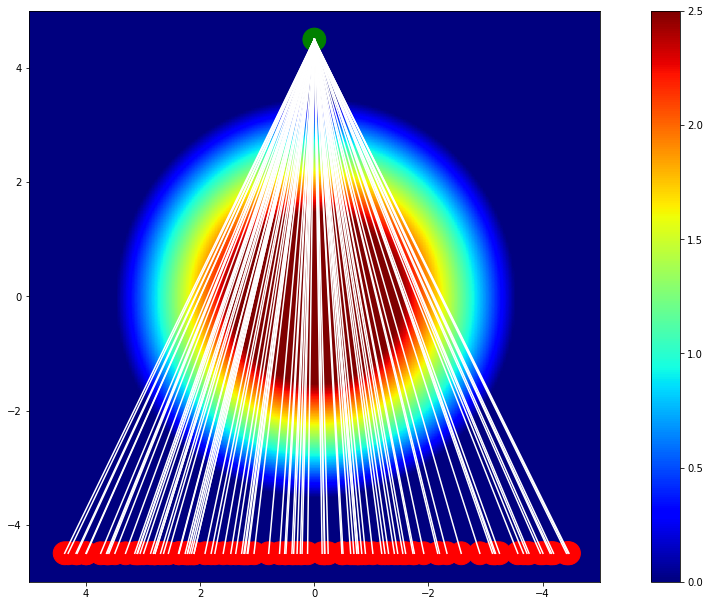

In [131]:


# fig = plt.figure()

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
p = plt.imshow(map_1, cmap='jet', extent=[max_y_1, min_y_1, min_x_1, max_x_1])

start_circ = plt.Circle(start_pos[::-1], size, color='g')
ax.add_patch(start_circ)

for goal in goals:
    goal_circ = plt.Circle((goal[1], goal[0]), size, color='r')
    ax.add_patch(goal_circ)
    plt.plot([start_pos[1], goal[1]], [start_pos[0], goal[0]], color='w')


plt.colorbar(p)
plt.show()